# neuroBrite 2020 - Behaviour notebook

This notebook allows you to collect behavioural data (accuracy and reaction time) and analyse it.

In the task you will see images of faces and buildings. Most of the faces will be adults but occasionally we will present baby faces. Most of the buildings with be houses but occasionally we will present images of castles. There are three versions of the task.

1. Count how many baby faces are presented
2. Count how many castles are presented
3. Count both babies *and* castles

In all versions of the task you should press one key for faces (of any age) and one key for buildings (of any type).

In [1]:
# this cell loads the things we will need (make sure to run this!)
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
#from mne import Epochs, find_events
from time import time, strftime, gmtime
import os, glob
import pandas as pd
from stimulus_presentation import nb2020_rt
#from utils import utils
#from collections import OrderedDict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Run the experiment

The cell below runs the experiment:

- Press the `z` key in response to faces
- Press the `m` key in response to buildings

Try to respond as quickly and as accurately as possible!

<!--
It is also possible to run the experiment from the psychopy app
the script is 
eeg-notebooks/notebooks/stimulus_presentation/nb2020_rt.py
-->

In [2]:
subject = 1
version = 1 # 1 = count babies, 2 = count castles, 3 = count babies and castles
duration = 5 #120

nb2020_rt.present(duration=duration, subj_num=subject, version_num=version)

/Users/stephenrhodes/eeg-notebooks/notebooks/stimulus_presentation/stim/nb2020
1.1999 	WARNING 	User requested fullscreen with size [1600  900], but screen is actually [1280, 800]. Using actual size


# Read the data

In [2]:
# enter the subject number you want to load
subject = 1
versions = [1,2,3] # which conditions should we read in?

d_list = []
for v in versions:
    data_path = os.path.join(os.path.expanduser("~"), "eeg-notebooks", "data", "visual", 
                         "nb2020_rt", "subject" + str(subject), "version" + str(v)) + "/"

    # combine all data files
    filenames = [i for i in glob.glob(data_path + '*.{}'.format("csv"))]
    v_data = pd.concat([pd.read_csv(f) for f in filenames])

    # drop missing values
    clean_data = v_data.dropna()

    print("version %i: %.2f%% missing data (no response given)" % (v, 100*(1 - len(clean_data.index)/ len(v_data.index))) )
    
    v_data['version'] = v # add version to a column
    
    d_list.append(v_data)
    
# combine all data sets
all_data = pd.concat(d_list)

# add column for accuracy
# image_type = 1 = faces
all_data["resp_type"] = pd.Series(all_data.resps == 'z', index=all_data.index, dtype='int64') 
all_data["acc"] = pd.Series(all_data.resp_type == all_data.image_type, index=all_data.index, dtype='int64') 

# aggregate data
agg_data = all_data.groupby(["version", "mark"]).agg(
    {
         'rts': ['count', 'mean', 'std', 'sem'],
        'acc': ['count', 'mean', 'std', 'sem']
    }
)

agg_data

version 1: 85.29% missing data (no response given)
version 2: 84.73% missing data (no response given)
version 3: 84.39% missing data (no response given)


rts                                 acc                      \
             count      mean       std       sem count      mean       std   
version mark                                                                 
1       0       22  0.460456  0.069196  0.014753   160  0.125000  0.331757   
        1        3  0.407072  0.078859  0.045529    22  0.136364  0.351250   
        2       26  0.444955  0.089817  0.017614   163  0.981595  0.134825   
        3        4  0.459500  0.104079  0.052039    29  0.965517  0.185695   
2       0       18  0.450432  0.067811  0.015983   127  0.125984  0.333146   
        1        3  0.407072  0.078859  0.045529    16  0.187500  0.403113   
        2       19  0.436420  0.060840  0.013958   114  0.973684  0.160779   
        3        2  0.517818  0.117865  0.083343    18  0.944444  0.235702   
3       0       19  0.451608  0.066100  0.015164   136  0.117647  0.323381   
        1        4  0.410238  0.064698  0.032349    20  0.200000  0.410391   
        2       22  0.453661  0.076966  0.016409   124  0.975806  0.154273   
        3        2  0.517818  0.117865  0.083343    21  0.952381  0.218218   

                        
                   sem  
version mark            
1       0     0.026228  
        1     0.074887  
        2     0.010560  
        3     0.034483  
2       0     0.029562  
        1     0.100778  
        2     0.015058  
        3     0.055556  
3       0     0.027730  
        1     0.091766  
        2     0.013854  
        3     0.047619

# Reaction times

The plot below shows average reaction time for the two types of face stimuli and the two types of buildings.

Which stimuli elicit the fastest and slowest reaction times?

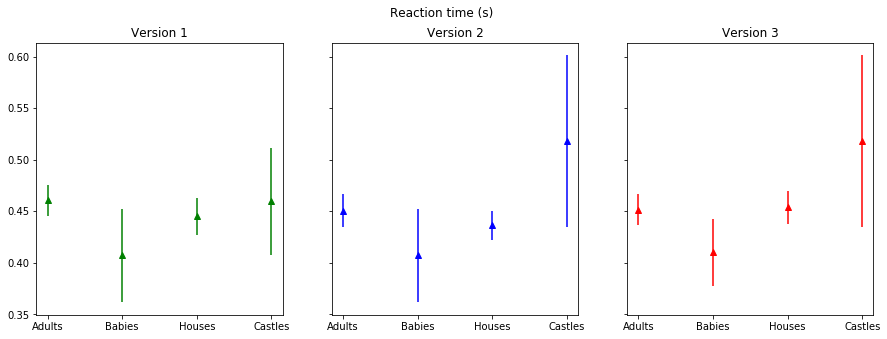

In [3]:

stim_labels = ["Adults","Babies","Houses","Castles"]
colors = ["green", "blue", "red"]

fig, ax = plt.subplots(1, len(versions), sharey=True, figsize=(15,5))
fig.suptitle("Reaction time (s)")

for i in range(len(versions)):
    plt_data = agg_data.groupby('version').get_group(versions[i])

    mean_rt = plt_data["rts"]['mean'] # average reaction time
    se_rt = plt_data["rts"]['sem'] # standard error (measure of how uncertain we are about the average)
    
    ax[i].errorbar(stim_labels, mean_rt, se_rt, linestyle='None', marker='^', color=colors[versions[i] - 1])
    ax[i].set_title('Version %i' % versions[i])
   

# Accuracy

The plot below shows accuracy for the two types of face stimuli and the two types of buildings.

Were participants more or less accurate for specific stimuli?

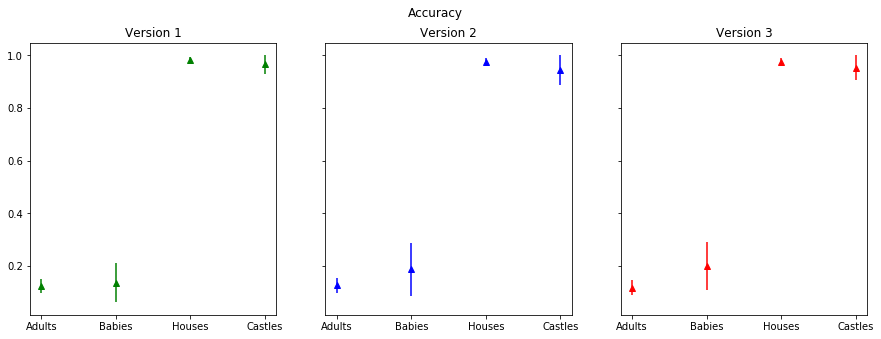

In [4]:

fig, ax = plt.subplots(1, len(versions), sharey=True, figsize=(15,5))
fig.suptitle("Accuracy")

for i in range(len(versions)):
    plt_data = agg_data.groupby('version').get_group(versions[i])

    mean_acc = plt_data["acc"]['mean'] # average accuracy
    se_acc = plt_data["acc"]['sem'] # uncertainty in the average
    
    ax[i].errorbar(stim_labels, mean_acc, se_acc, linestyle='None', marker='^', color=colors[i])
    ax[i].set_title('Version %i' % versions[i])
